# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 1.3401
Epoch 1/200, Iteration 2/12, Loss: 0.6921
Epoch 1/200, Iteration 3/12, Loss: 4.1218
Epoch 1/200, Iteration 4/12, Loss: 0.5219
Epoch 1/200, Iteration 5/12, Loss: 0.5203
Epoch 1/200, Iteration 6/12, Loss: 0.2762
Epoch 1/200, Iteration 7/12, Loss: 0.2977
Epoch 1/200, Iteration 8/12, Loss: 0.4111
Epoch 1/200, Iteration 9/12, Loss: 0.3569
Epoch 1/200, Iteration 10/12, Loss: 0.2235
Epoch 1/200, Iteration 11/12, Loss: 0.2021
Epoch 1/200, Iteration 12/12, Loss: 0.2346
Epoch 1/200, Iteration 13/12, Loss: 0.2593
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.202837, MRE: 0.272478, MAE: 0.049808 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.208476, MRE: 0.230452, MAE: 0.051122 

Epoch 2/200, Iteration 1/12, Loss: 0.1730
Epoch 2/200, Iteration 2/12, Loss: 0.2352
Epoch 2/200, Iteration 3/12, Loss: 0.1832
Epoch 2/200, Iteration 4/12, Loss: 0.2345
Epoch 2/200, Iteration 5/12, Loss: 0.1628
Epoch 2/200, Iteration 6/12, Loss: 0.1395
Epoch 2/200, Iteration 7/12, Loss

Epoch 13/200, Iteration 3/12, Loss: 0.0042
Epoch 13/200, Iteration 4/12, Loss: 0.0027
Epoch 13/200, Iteration 5/12, Loss: 0.0036
Epoch 13/200, Iteration 6/12, Loss: 0.0021
Epoch 13/200, Iteration 7/12, Loss: 0.0039
Epoch 13/200, Iteration 8/12, Loss: 0.0021
Epoch 13/200, Iteration 9/12, Loss: 0.0026
Epoch 13/200, Iteration 10/12, Loss: 0.0025
Epoch 13/200, Iteration 11/12, Loss: 0.0021
Epoch 13/200, Iteration 12/12, Loss: 0.0028
Epoch 13/200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.002709, MRE: 0.031791, MAE: 0.004868 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002415, MRE: 0.027703, MAE: 0.004536 

Epoch 14/200, Iteration 1/12, Loss: 0.0026
Epoch 14/200, Iteration 2/12, Loss: 0.0016
Epoch 14/200, Iteration 3/12, Loss: 0.0035
Epoch 14/200, Iteration 4/12, Loss: 0.0035
Epoch 14/200, Iteration 5/12, Loss: 0.0017
Epoch 14/200, Iteration 6/12, Loss: 0.0024
Epoch 14/200, Iteration 7/12, Loss: 0.0019
Epoch 14/200, Iteration 8/12, Loss: 0.0021
Epoch 14/200,

Epoch 25/200, Iteration 10/12, Loss: 0.0008
Epoch 25/200, Iteration 11/12, Loss: 0.0014
Epoch 25/200, Iteration 12/12, Loss: 0.0013
Epoch 25/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000929, MRE: 0.021192, MAE: 0.002919 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001121, MRE: 0.019594, MAE: 0.003358 

Epoch 26/200, Iteration 1/12, Loss: 0.0008
Epoch 26/200, Iteration 2/12, Loss: 0.0006
Epoch 26/200, Iteration 3/12, Loss: 0.0015
Epoch 26/200, Iteration 4/12, Loss: 0.0008
Epoch 26/200, Iteration 5/12, Loss: 0.0018
Epoch 26/200, Iteration 6/12, Loss: 0.0017
Epoch 26/200, Iteration 7/12, Loss: 0.0012
Epoch 26/200, Iteration 8/12, Loss: 0.0018
Epoch 26/200, Iteration 9/12, Loss: 0.0012
Epoch 26/200, Iteration 10/12, Loss: 0.0015
Epoch 26/200, Iteration 11/12, Loss: 0.0019
Epoch 26/200, Iteration 12/12, Loss: 0.0016
Epoch 26/200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 88.25%, Avg loss: 0.003519, MRE: 0.031991, MAE: 0.004443 

Test Error: 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007766, MRE: 0.043356, MAE: 0.009765 

Epoch 37/200, Iteration 1/12, Loss: 0.0057
Epoch 37/200, Iteration 2/12, Loss: 0.0097
Epoch 37/200, Iteration 3/12, Loss: 0.0065
Epoch 37/200, Iteration 4/12, Loss: 0.0052
Epoch 37/200, Iteration 5/12, Loss: 0.0074
Epoch 37/200, Iteration 6/12, Loss: 0.0040
Epoch 37/200, Iteration 7/12, Loss: 0.0029
Epoch 37/200, Iteration 8/12, Loss: 0.0031
Epoch 37/200, Iteration 9/12, Loss: 0.0018
Epoch 37/200, Iteration 10/12, Loss: 0.0028
Epoch 37/200, Iteration 11/12, Loss: 0.0017
Epoch 37/200, Iteration 12/12, Loss: 0.0038
Epoch 37/200, Iteration 13/12, Loss: 0.0031
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.002928, MRE: 0.023306, MAE: 0.005087 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.002231, MRE: 0.020580, MAE: 0.005017 

Epoch 38/200, Iteration 1/12, Loss: 0.0032
Epoch 38/200, Iteration 2/12, Loss: 0.0014
Epoch 38/200, Iteration 3/12, Loss: 0.0034
Epoch 38/200, Iteration 4/12, Loss: 0.0026
Epoch 38/200, Ite

Epoch 48/200, Iteration 9/12, Loss: 0.0005
Epoch 48/200, Iteration 10/12, Loss: 0.0003
Epoch 48/200, Iteration 11/12, Loss: 0.0002
Epoch 48/200, Iteration 12/12, Loss: 0.0003
Epoch 48/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000229, MRE: 0.007907, MAE: 0.001294 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000299, MRE: 0.007709, MAE: 0.001505 

Epoch 49/200, Iteration 1/12, Loss: 0.0002
Epoch 49/200, Iteration 2/12, Loss: 0.0001
Epoch 49/200, Iteration 3/12, Loss: 0.0001
Epoch 49/200, Iteration 4/12, Loss: 0.0002
Epoch 49/200, Iteration 5/12, Loss: 0.0002
Epoch 49/200, Iteration 6/12, Loss: 0.0002
Epoch 49/200, Iteration 7/12, Loss: 0.0006
Epoch 49/200, Iteration 8/12, Loss: 0.0002
Epoch 49/200, Iteration 9/12, Loss: 0.0002
Epoch 49/200, Iteration 10/12, Loss: 0.0005
Epoch 49/200, Iteration 11/12, Loss: 0.0004
Epoch 49/200, Iteration 12/12, Loss: 0.0003
Epoch 49/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000231,

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000246, MRE: 0.006957, MAE: 0.001407 

Epoch 60/200, Iteration 1/12, Loss: 0.0003
Epoch 60/200, Iteration 2/12, Loss: 0.0001
Epoch 60/200, Iteration 3/12, Loss: 0.0001
Epoch 60/200, Iteration 4/12, Loss: 0.0001
Epoch 60/200, Iteration 5/12, Loss: 0.0003
Epoch 60/200, Iteration 6/12, Loss: 0.0001
Epoch 60/200, Iteration 7/12, Loss: 0.0001
Epoch 60/200, Iteration 8/12, Loss: 0.0004
Epoch 60/200, Iteration 9/12, Loss: 0.0001
Epoch 60/200, Iteration 10/12, Loss: 0.0002
Epoch 60/200, Iteration 11/12, Loss: 0.0001
Epoch 60/200, Iteration 12/12, Loss: 0.0002
Epoch 60/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000172, MRE: 0.007470, MAE: 0.001125 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000238, MRE: 0.006960, MAE: 0.001377 

Epoch 61/200, Iteration 1/12, Loss: 0.0002
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0006
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Ite

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000149, MRE: 0.007657, MAE: 0.001122 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000209, MRE: 0.006430, MAE: 0.001354 

Epoch 72/200, Iteration 1/12, Loss: 0.0002
Epoch 72/200, Iteration 2/12, Loss: 0.0002
Epoch 72/200, Iteration 3/12, Loss: 0.0001
Epoch 72/200, Iteration 4/12, Loss: 0.0001
Epoch 72/200, Iteration 5/12, Loss: 0.0002
Epoch 72/200, Iteration 6/12, Loss: 0.0001
Epoch 72/200, Iteration 7/12, Loss: 0.0002
Epoch 72/200, Iteration 8/12, Loss: 0.0003
Epoch 72/200, Iteration 9/12, Loss: 0.0002
Epoch 72/200, Iteration 10/12, Loss: 0.0001
Epoch 72/200, Iteration 11/12, Loss: 0.0001
Epoch 72/200, Iteration 12/12, Loss: 0.0001
Epoch 72/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000153, MRE: 0.007602, MAE: 0.001099 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000205, MRE: 0.006345, MAE: 0.001352 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0002
Epoch 73/200, Itera

Epoch 83/200, Iteration 3/12, Loss: 0.0001
Epoch 83/200, Iteration 4/12, Loss: 0.0002
Epoch 83/200, Iteration 5/12, Loss: 0.0001
Epoch 83/200, Iteration 6/12, Loss: 0.0002
Epoch 83/200, Iteration 7/12, Loss: 0.0001
Epoch 83/200, Iteration 8/12, Loss: 0.0002
Epoch 83/200, Iteration 9/12, Loss: 0.0001
Epoch 83/200, Iteration 10/12, Loss: 0.0001
Epoch 83/200, Iteration 11/12, Loss: 0.0001
Epoch 83/200, Iteration 12/12, Loss: 0.0001
Epoch 83/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000118, MRE: 0.006598, MAE: 0.000956 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000184, MRE: 0.006076, MAE: 0.001231 

Epoch 84/200, Iteration 1/12, Loss: 0.0001
Epoch 84/200, Iteration 2/12, Loss: 0.0001
Epoch 84/200, Iteration 3/12, Loss: 0.0001
Epoch 84/200, Iteration 4/12, Loss: 0.0002
Epoch 84/200, Iteration 5/12, Loss: 0.0001
Epoch 84/200, Iteration 6/12, Loss: 0.0002
Epoch 84/200, Iteration 7/12, Loss: 0.0001
Epoch 84/200, Iteration 8/12, Loss: 0.0001
Epoch 84/200,

Epoch 95/200, Iteration 10/12, Loss: 0.0002
Epoch 95/200, Iteration 11/12, Loss: 0.0001
Epoch 95/200, Iteration 12/12, Loss: 0.0001
Epoch 95/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007909, MAE: 0.000907 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000160, MRE: 0.005997, MAE: 0.001143 

Epoch 96/200, Iteration 1/12, Loss: 0.0001
Epoch 96/200, Iteration 2/12, Loss: 0.0001
Epoch 96/200, Iteration 3/12, Loss: 0.0001
Epoch 96/200, Iteration 4/12, Loss: 0.0001
Epoch 96/200, Iteration 5/12, Loss: 0.0001
Epoch 96/200, Iteration 6/12, Loss: 0.0002
Epoch 96/200, Iteration 7/12, Loss: 0.0001
Epoch 96/200, Iteration 8/12, Loss: 0.0001
Epoch 96/200, Iteration 9/12, Loss: 0.0001
Epoch 96/200, Iteration 10/12, Loss: 0.0001
Epoch 96/200, Iteration 11/12, Loss: 0.0001
Epoch 96/200, Iteration 12/12, Loss: 0.0001
Epoch 96/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000099, MRE: 0.006405, MAE: 0.000883 

Test Error:

Epoch 107/200, Iteration 2/12, Loss: 0.0001
Epoch 107/200, Iteration 3/12, Loss: 0.0001
Epoch 107/200, Iteration 4/12, Loss: 0.0002
Epoch 107/200, Iteration 5/12, Loss: 0.0001
Epoch 107/200, Iteration 6/12, Loss: 0.0001
Epoch 107/200, Iteration 7/12, Loss: 0.0001
Epoch 107/200, Iteration 8/12, Loss: 0.0001
Epoch 107/200, Iteration 9/12, Loss: 0.0001
Epoch 107/200, Iteration 10/12, Loss: 0.0001
Epoch 107/200, Iteration 11/12, Loss: 0.0001
Epoch 107/200, Iteration 12/12, Loss: 0.0002
Epoch 107/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000093, MRE: 0.006129, MAE: 0.000861 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000142, MRE: 0.005347, MAE: 0.001103 

Epoch 108/200, Iteration 1/12, Loss: 0.0001
Epoch 108/200, Iteration 2/12, Loss: 0.0001
Epoch 108/200, Iteration 3/12, Loss: 0.0001
Epoch 108/200, Iteration 4/12, Loss: 0.0001
Epoch 108/200, Iteration 5/12, Loss: 0.0001
Epoch 108/200, Iteration 6/12, Loss: 0.0001
Epoch 108/200, Iteration 7/12, Loss: 

Epoch 118/200, Iteration 6/12, Loss: 0.0001
Epoch 118/200, Iteration 7/12, Loss: 0.0000
Epoch 118/200, Iteration 8/12, Loss: 0.0001
Epoch 118/200, Iteration 9/12, Loss: 0.0001
Epoch 118/200, Iteration 10/12, Loss: 0.0001
Epoch 118/200, Iteration 11/12, Loss: 0.0002
Epoch 118/200, Iteration 12/12, Loss: 0.0001
Epoch 118/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000087, MRE: 0.007635, MAE: 0.000828 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000135, MRE: 0.005152, MAE: 0.001090 

Epoch 119/200, Iteration 1/12, Loss: 0.0001
Epoch 119/200, Iteration 2/12, Loss: 0.0001
Epoch 119/200, Iteration 3/12, Loss: 0.0001
Epoch 119/200, Iteration 4/12, Loss: 0.0003
Epoch 119/200, Iteration 5/12, Loss: 0.0001
Epoch 119/200, Iteration 6/12, Loss: 0.0001
Epoch 119/200, Iteration 7/12, Loss: 0.0002
Epoch 119/200, Iteration 8/12, Loss: 0.0002
Epoch 119/200, Iteration 9/12, Loss: 0.0001
Epoch 119/200, Iteration 10/12, Loss: 0.0001
Epoch 119/200, Iteration 11/12, Loss

Epoch 130/200, Iteration 7/12, Loss: 0.0001
Epoch 130/200, Iteration 8/12, Loss: 0.0001
Epoch 130/200, Iteration 9/12, Loss: 0.0001
Epoch 130/200, Iteration 10/12, Loss: 0.0001
Epoch 130/200, Iteration 11/12, Loss: 0.0002
Epoch 130/200, Iteration 12/12, Loss: 0.0002
Epoch 130/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000108, MRE: 0.006859, MAE: 0.001004 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.005983, MAE: 0.001139 

Epoch 131/200, Iteration 1/12, Loss: 0.0001
Epoch 131/200, Iteration 2/12, Loss: 0.0001
Epoch 131/200, Iteration 3/12, Loss: 0.0001
Epoch 131/200, Iteration 4/12, Loss: 0.0001
Epoch 131/200, Iteration 5/12, Loss: 0.0002
Epoch 131/200, Iteration 6/12, Loss: 0.0001
Epoch 131/200, Iteration 7/12, Loss: 0.0001
Epoch 131/200, Iteration 8/12, Loss: 0.0001
Epoch 131/200, Iteration 9/12, Loss: 0.0001
Epoch 131/200, Iteration 10/12, Loss: 0.0001
Epoch 131/200, Iteration 11/12, Loss: 0.0001
Epoch 131/200, Iteration 12/12, Los

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.004666, MAE: 0.000932 

Epoch 142/200, Iteration 1/12, Loss: 0.0001
Epoch 142/200, Iteration 2/12, Loss: 0.0001
Epoch 142/200, Iteration 3/12, Loss: 0.0001
Epoch 142/200, Iteration 4/12, Loss: 0.0001
Epoch 142/200, Iteration 5/12, Loss: 0.0001
Epoch 142/200, Iteration 6/12, Loss: 0.0002
Epoch 142/200, Iteration 7/12, Loss: 0.0001
Epoch 142/200, Iteration 8/12, Loss: 0.0001
Epoch 142/200, Iteration 9/12, Loss: 0.0001
Epoch 142/200, Iteration 10/12, Loss: 0.0002
Epoch 142/200, Iteration 11/12, Loss: 0.0002
Epoch 142/200, Iteration 12/12, Loss: 0.0001
Epoch 142/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000100, MRE: 0.006480, MAE: 0.000938 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.005079, MAE: 0.001084 

Epoch 143/200, Iteration 1/12, Loss: 0.0001
Epoch 143/200, Iteration 2/12, Loss: 0.0001
Epoch 143/200, Iteration 3/12, Loss: 0.0001
Epoch 143/200, Iteration 4/12, Loss: 0.000

Epoch 153/200, Iteration 4/12, Loss: 0.0001
Epoch 153/200, Iteration 5/12, Loss: 0.0001
Epoch 153/200, Iteration 6/12, Loss: 0.0001
Epoch 153/200, Iteration 7/12, Loss: 0.0001
Epoch 153/200, Iteration 8/12, Loss: 0.0000
Epoch 153/200, Iteration 9/12, Loss: 0.0001
Epoch 153/200, Iteration 10/12, Loss: 0.0000
Epoch 153/200, Iteration 11/12, Loss: 0.0001
Epoch 153/200, Iteration 12/12, Loss: 0.0000
Epoch 153/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000054, MRE: 0.005415, MAE: 0.000735 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000100, MRE: 0.004430, MAE: 0.000886 

Epoch 154/200, Iteration 1/12, Loss: 0.0001
Epoch 154/200, Iteration 2/12, Loss: 0.0001
Epoch 154/200, Iteration 3/12, Loss: 0.0001
Epoch 154/200, Iteration 4/12, Loss: 0.0000
Epoch 154/200, Iteration 5/12, Loss: 0.0000
Epoch 154/200, Iteration 6/12, Loss: 0.0000
Epoch 154/200, Iteration 7/12, Loss: 0.0000
Epoch 154/200, Iteration 8/12, Loss: 0.0001
Epoch 154/200, Iteration 9/12, Loss: 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000102, MRE: 0.005586, MAE: 0.000873 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.004542, MAE: 0.001002 

Epoch 165/200, Iteration 1/12, Loss: 0.0001
Epoch 165/200, Iteration 2/12, Loss: 0.0001
Epoch 165/200, Iteration 3/12, Loss: 0.0001
Epoch 165/200, Iteration 4/12, Loss: 0.0001
Epoch 165/200, Iteration 5/12, Loss: 0.0001
Epoch 165/200, Iteration 6/12, Loss: 0.0001
Epoch 165/200, Iteration 7/12, Loss: 0.0000
Epoch 165/200, Iteration 8/12, Loss: 0.0001
Epoch 165/200, Iteration 9/12, Loss: 0.0001
Epoch 165/200, Iteration 10/12, Loss: 0.0001
Epoch 165/200, Iteration 11/12, Loss: 0.0001
Epoch 165/200, Iteration 12/12, Loss: 0.0001
Epoch 165/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000062, MRE: 0.005526, MAE: 0.000734 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.004959, MAE: 0.000997 

Epoch 166/200, Iteration 1/12, Loss: 0.0000
Epoch 166/200, Iteration 2/12, Loss: 0.0000
Ep

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000106, MRE: 0.004632, MAE: 0.000913 

Epoch 176/200, Iteration 1/12, Loss: 0.0001
Epoch 176/200, Iteration 2/12, Loss: 0.0000
Epoch 176/200, Iteration 3/12, Loss: 0.0000
Epoch 176/200, Iteration 4/12, Loss: 0.0001
Epoch 176/200, Iteration 5/12, Loss: 0.0000
Epoch 176/200, Iteration 6/12, Loss: 0.0001
Epoch 176/200, Iteration 7/12, Loss: 0.0001
Epoch 176/200, Iteration 8/12, Loss: 0.0000
Epoch 176/200, Iteration 9/12, Loss: 0.0000
Epoch 176/200, Iteration 10/12, Loss: 0.0001
Epoch 176/200, Iteration 11/12, Loss: 0.0001
Epoch 176/200, Iteration 12/12, Loss: 0.0001
Epoch 176/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.007211, MAE: 0.001252 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000149, MRE: 0.005809, MAE: 0.001231 

Epoch 177/200, Iteration 1/12, Loss: 0.0001
Epoch 177/200, Iteration 2/12, Loss: 0.0002
Epoch 177/200, Iteration 3/12, Loss: 0.0001
Epoch 177/200, Iteration 4/12, Loss: 0.000

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000089, MRE: 0.004216, MAE: 0.000908 

Epoch 188/200, Iteration 1/12, Loss: 0.0001
Epoch 188/200, Iteration 2/12, Loss: 0.0001
Epoch 188/200, Iteration 3/12, Loss: 0.0001
Epoch 188/200, Iteration 4/12, Loss: 0.0000
Epoch 188/200, Iteration 5/12, Loss: 0.0001
Epoch 188/200, Iteration 6/12, Loss: 0.0000
Epoch 188/200, Iteration 7/12, Loss: 0.0001
Epoch 188/200, Iteration 8/12, Loss: 0.0000
Epoch 188/200, Iteration 9/12, Loss: 0.0001
Epoch 188/200, Iteration 10/12, Loss: 0.0000
Epoch 188/200, Iteration 11/12, Loss: 0.0000
Epoch 188/200, Iteration 12/12, Loss: 0.0000
Epoch 188/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.004835, MAE: 0.000692 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000090, MRE: 0.004289, MAE: 0.000872 

Epoch 189/200, Iteration 1/12, Loss: 0.0000
Epoch 189/200, Iteration 2/12, Loss: 0.0001
Epoch 189/200, Iteration 3/12, Loss: 0.0000
Epoch 189/200, Iteration 4/12, Loss: 0.000

Epoch 199/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.004858, MAE: 0.000724 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.004731, MAE: 0.000999 

Epoch 200/200, Iteration 1/12, Loss: 0.0001
Epoch 200/200, Iteration 2/12, Loss: 0.0001
Epoch 200/200, Iteration 3/12, Loss: 0.0000
Epoch 200/200, Iteration 4/12, Loss: 0.0001
Epoch 200/200, Iteration 5/12, Loss: 0.0001
Epoch 200/200, Iteration 6/12, Loss: 0.0001
Epoch 200/200, Iteration 7/12, Loss: 0.0001
Epoch 200/200, Iteration 8/12, Loss: 0.0001
Epoch 200/200, Iteration 9/12, Loss: 0.0001
Epoch 200/200, Iteration 10/12, Loss: 0.0001
Epoch 200/200, Iteration 11/12, Loss: 0.0001
Epoch 200/200, Iteration 12/12, Loss: 0.0001
Epoch 200/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000068, MRE: 0.006235, MAE: 0.000835 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000099, MRE: 0.004835, MAE: 0.000958 



#### Plots loss vs Epoch

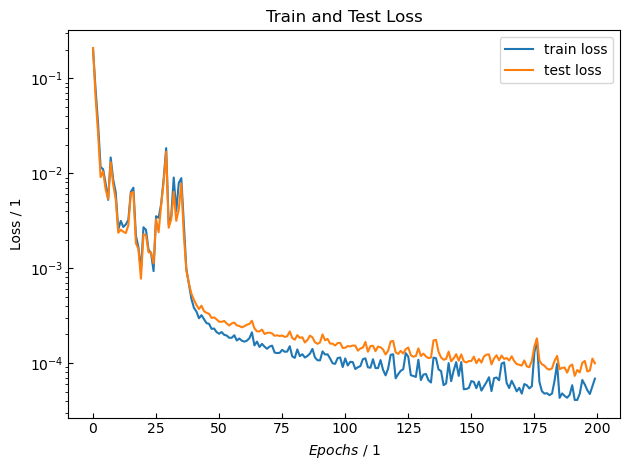

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999492213805513 , R^2(NH3) = 0.9999163958002741
Test Dataset: R^2(H2) = 0.9999195037132561 , R^2(NH3) = 0.9998784746501067
Max Error Training: |x_H2 - x_H2,pred| = 0.008189950126863077 , |x_NH3 - x_NH3,pred| = 0.005665192412924527
Max Error Test: |x_H2 - x_H2,pred| = 0.005274318360339092 , |x_NH3 - x_NH3,pred| = 0.0079269840528165


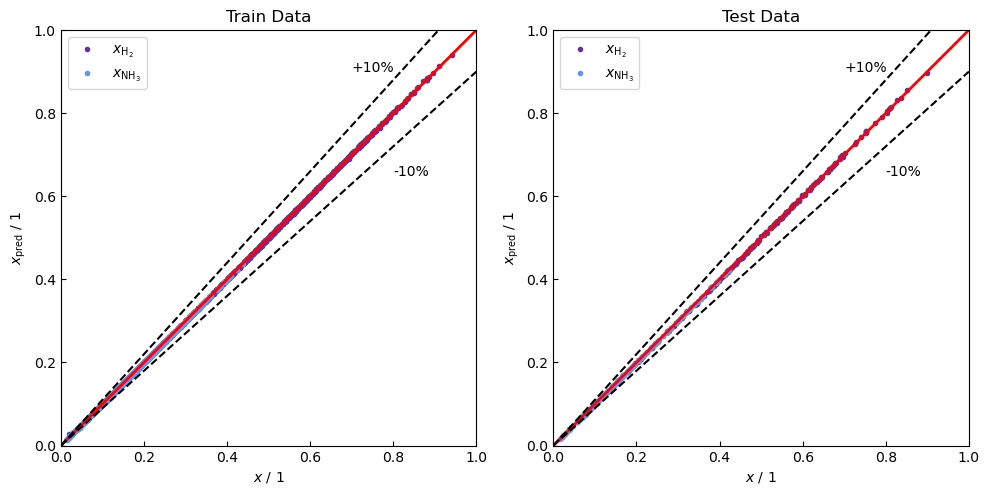

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

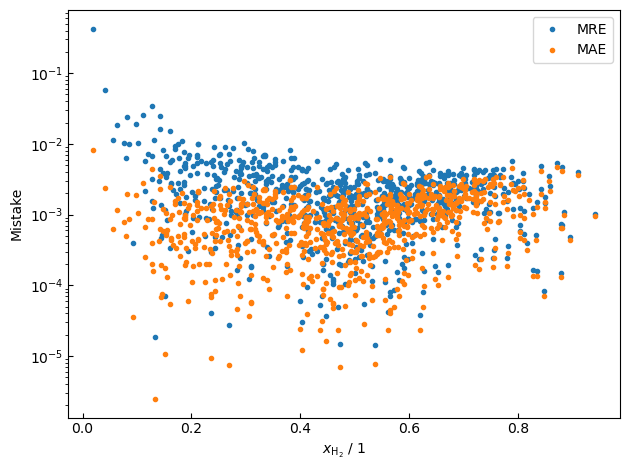

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

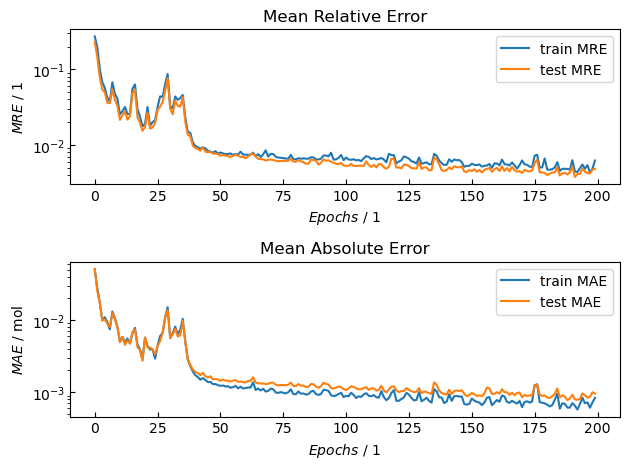

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

In [21]:
#np.savez('data/models/hyperparams/loss_005_019.npz', train_loss = train_MAE, test_loss = test_MAE)

#### Plot Loss vs Variable Properties

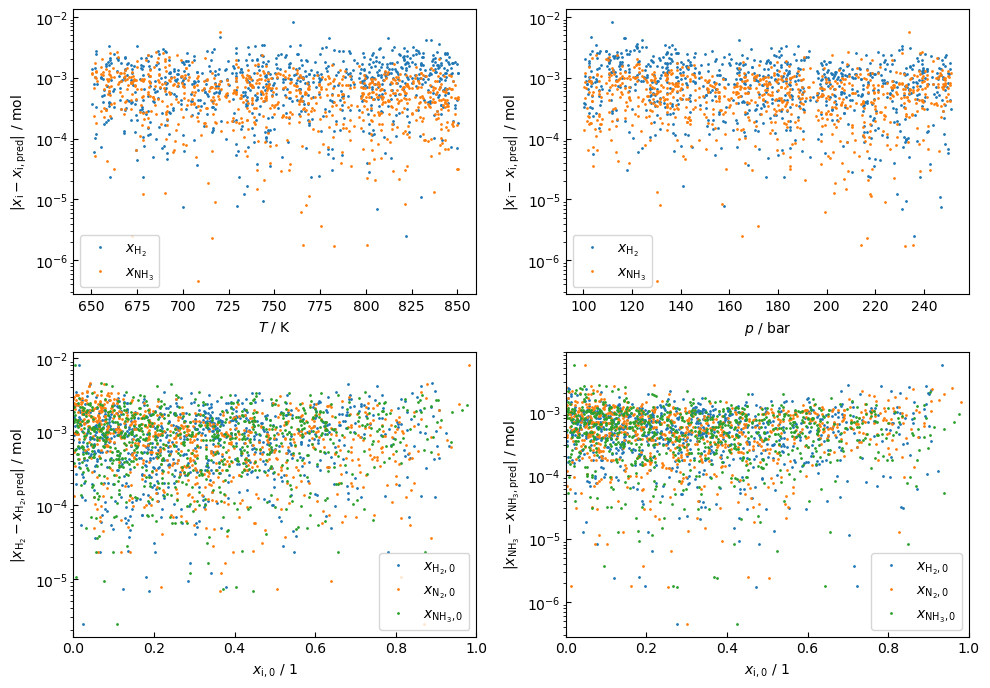

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

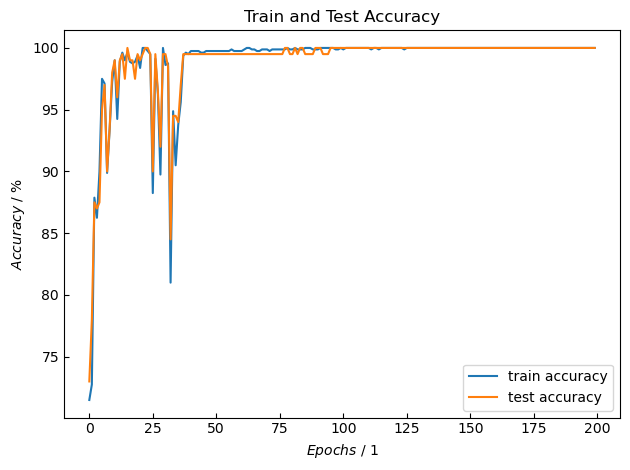

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-0.0706,  0.5163, -1.1562,  1.7878, -0.6926],
        [-1.3642,  1.0586,  0.9155, -1.0843,  0.2098],
        [ 0.3445, -0.0847,  1.6464, -0.5924, -1.0103],
        [-0.8112, -0.9401,  0.6949, -0.6076, -0.0610],
        [-0.9382,  0.1907,  0.4247, -0.6121,  0.2089],
        [ 1.2257, -1.3317,  0.9983, -0.1846, -0.7910],
        [ 1.0805,  1.4381, -0.3820,  0.6188, -0.2576],
        [ 0.4482,  0.8906,  0.8755,  0.0900, -0.9511],
        [-0.6332,  0.3415, -0.5108,  0.6895, -0.2034],
        [ 0.8926,  1.3409, -1.2877,  0.7392,  0.5082],
        [-1.3295, -0.3446,  1.7009, -0.6744, -0.9800],
        [ 0.8175,  0.6694, -1.0789, -0.1975,  1.2607],
        [-0.7719,  0.9031, -0.0169, -0.2096,  0.2308],
        [-1.2688, -0.4607,  0.3348, -0.4567,  0.1382],
        [ 1.4968, -1.0971, -0.4164,  0.0994,  0.3071],
        [-0.4310, -0.7398, -1.2365,  2.3729, -1.2118],
        [-1.2486,  1.1284, -1.0758,  1.8898, -0.8757],
        [-0.8579, -0.2257, -1.3216,  1.7369, -0.4782],
        [-

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 3.4303e-01, -2.0054e-01,  1.7678e-01, -3.9235e-01,  3.0648e-01],
         [-7.1884e-02, -1.1804e-01,  2.7212e-01, -1.6631e-01,  1.8645e-01],
         [ 2.2398e-01,  2.9080e-01, -1.8951e-02,  4.1399e-01,  2.5101e-01],
         [ 1.8698e-01, -1.0547e-01,  6.3651e-03,  1.7447e-01,  1.1439e-01],
         [-1.7909e-01, -2.2445e-01, -2.8908e-01, -2.6785e-01,  3.6909e-01],
         [-6.3659e-02,  9.1364e-02, -5.6329e-02, -3.4368e-01, -1.9522e-01],
         [-3.6948e-01, -4.8809e-02, -1.4515e-01,  6.3091e-02,  9.4408e-02],
         [-1.6899e-01, -3.6565e-01,  1.0287e-01, -8.9272e-02, -4.0071e-02],
         [-5.6976e-02,  1.2086e-01, -2.8693e-01,  2.2969e-01, -3.2655e-01],
         [-4.5802e-01,  4.7573e-01,  2.3706e-01,  2.7014e-01, -8.9095e-03],
         [ 2.7216e-01,  1.0627e-03,  2.1844e-02, -2.1184e-01,  1.1772e-01],
         [ 4.1147e-01,  1.3523e-01,  3.8315e-01,  1.6431e-01,  8.3986e-02],
         [-3.1225e-01, -2.4432e-01,  1.5235e-01, -5.1909e-02, -2.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0387, 0.5914, 0.0017, 0.4511, 0.0812],
        [0.4367, 0.3465, 0.7700, 0.2880, 0.5172]])
tensor([[-0.3171,  0.1347],
        [ 0.2701,  0.0401]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.0850,  1.4037,  0.1139,  1.0708, -1.2062],
        [-0.2842,  1.2936, -0.2899, -0.1385,  0.4261],
        [ 1.5524,  1.6091,  0.2979,  1.0719, -1.3880],
        [-0.1724,  0.2046, -1.4377,  2.4526, -1.0958],
        [-0.4446,  0.6084, -0.8741,  1.3484, -0.5203],
        [ 0.8406, -0.7978, -0.5431,  1.7401, -1.2455],
        [-1.4109,  1.2076,  1.6388, -0.8858, -0.7029],
        [-1.6187,  1.1109,  0.8888,  0.3848, -1.2655],
        [-0.6383,  0.0080,  0.0749,  0.9148, -1.0085],
        [-1.3880,  1.5016, -0.4715, -0.7827,  1.2626],
        [-0.4000,  0.5277,  1.2556, -1.3198,  0.1167],
        [ 0.5427,  0.0982, -1.3514,  2.0746, -0.7942],
        [-0.7967,  0.7767,  2.4775, -1.1109, -1.2959],
        [-0.9545, -0.8333,  0.3136,  0.1780, -0.4897],
        [ 1.1586, -0.7642,  0.0174,  0.4298, -0.4564],
        [ 1.0499, -0.8096, -1.2616, -0.9861,  2.2460],
        [ 1.2716,  0.1273, -0.5196, -1.0607,  1.5940],
        [ 1.2453,  0.3896,  1.7950, -1.0085, -0.7308],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()